In [1]:
import os, sys
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from util import basic
print("Done!")

Done!


In [81]:
import seaborn as sns

In [2]:
import sys, os
import numpy as np
import gzip

## Load benchmark dataset 

In [46]:
seq_convert = {'N':'0', 'A':'1', 'C':'2', 'G':'3', 'T':'4'}

In [27]:
start_codon = ["ATG", "GTG", "TTG", "CTG", "ATT", "ATC"]

In [45]:
folder_name = (
    '/mnt/scratch7/hirak/Attention4DNASeqRepresentation/dataset/Predict_Bothways_pos_neg_example'
)

In [3]:
full_genome_file = (
    '/mnt/scratch7/hirak/Attention4DNASeqRepresentation/dataset/Predict_Bothways/forward_genes/forward_batch_0_0.gz'
)

In [189]:
def construct_postive_negative_samples(file_name):
    with gzip.open(file_name, 'rt', encoding='utf-8') as fp:
        seq_name = fp.readline().rstrip()
        seq_str = fp.readline().strip()
        coding_region = fp.readline().strip()
        encoded_gene = fp.readline().strip()
    
    print(len(seq_str))
        
    negative_samples = []
    positive_samples = []
    for i in range(len(seq_str)-100):
        sample = seq_str[i:i+101]
        convert = ''.join([seq_convert[sample[k]] for k in range(len(sample))])
        middle_codon = i + 49
        codon = seq_str[ middle_codon : middle_codon + 3 ]
        labelled_codon = encoded_gene[middle_codon:middle_codon+3]
        coding = coding_region[middle_codon]

        if ((codon in start_codon) and (labelled_codon == "111")):
            positive_samples += [list(convert)]
        elif ((codon in start_codon) and (coding == "0")):
            negative_samples += [list(convert)]
            
    return (positive_samples, negative_samples)

In [190]:
positive_samples, negative_samples = construct_postive_negative_samples(full_genome_file)

4641652


In [191]:
len(positive_samples), len(negative_samples)

(2012, 268728)

In [185]:
#positive_samples[0]

In [133]:
map(str,np.zeros(shape=(5000,101)))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [124]:
with open(os.path.join(folder_name,'forward_batch_0_0_positive.txt'), 'w') as fp:
    for s in positive_samples:
        fp.write('{}\n'.format(''.join(s)))
        
with open(os.path.join(folder_name,'forward_batch_0_0_negative.txt'), 'w') as fp:
    for s in negative_samples:
        fp.write('{}\n'.format(''.join(s)))

## Load the model 

In [125]:
def PCA(data, k=2):
    # preprocess the data
    # X = torch.from_numpy(data)
    pca_vec = []
    for X in data:
    
        X_mean = torch.mean(X,0)
        X = X - X_mean.expand_as(X)

        # svd
        U,S,V = torch.svd(torch.t(X))
        pca_vec += [torch.mm(X,U[:,:k]).squeeze().detach().numpy()]
    
    return pca_vec

In [64]:
class AttnDecoderRNN(nn.Module):#corrected batch faster
    #(self, time_steps, embedding_dim, hidden_dim, vocab_size, tagset_size, mini_batch)
    def __init__(self, vocab_size, embedding_dim, \
                 hidden_dim, device, batch_size=100, debug=1, \
                 tagset_size=1, time_steps=101):
        super(AttnDecoderRNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.time_steps = time_steps
        self.hidden_dim = hidden_dim
        self.minibatch_size = batch_size
        self.dropout_p = 0.25
        self.tagset_size = tagset_size
        self.hidden = self.init_hidden()
        self.debug = debug
        self.device = device 

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_one = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout_one = nn.Dropout(0.25)
        self.lstm_two = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout_two = nn.Dropout(0.25)

        self.attn_array = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for i in range(time_steps)])
        

        """
        self.attn_combine = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(self.dropout_p)
        self.linear = nn.Linear(hidden_dim, 1)
        #embedding_dim*time_steps
        """

        self.hidden2tag_one = nn.Linear(hidden_dim*time_steps, 512)
        self.dropout_three = nn.Dropout(0.25)
        self.hidden2tag_two = nn.Linear(512, 128)
        self.dropout_four = nn.Dropout(0.25)
        self.hidden2tag_three = nn.Linear(128, 64)
        self.dropout_five = nn.Dropout(0.25)

        self.output = nn.Linear(64, tagset_size)

    def forward(self, input):
        init_embed = self.embedding(input)
        #embedded = init_embed.permute(1, 0, 2)
        if self.debug == 1:
            print("Embedding Shape: ", init_embed.shape)

        lstm_out, self.hidden_one = self.lstm_one(init_embed, self.hidden)
        lstm_out = self.dropout_one(lstm_out)
        lstm_out, self.hidden_two = self.lstm_two(lstm_out, self.hidden)
        lstm_out = self.dropout_two(lstm_out)
        #"""
        lstm_permute = lstm_out.permute(1, 0, 2)
        if self.debug == 1:
            print("LSTM Out Shape: ", lstm_permute.shape)

        attention = [self.attn_array[i](lstm_permute[i][:]) for i in range(self.time_steps)]
        attention = torch.stack(attention)
        attention.to(device)
        
        attention = attention.permute(1, 0, 2)
        if self.debug == 1:
            print("Attention Shape: ", attention.shape)


        
        attn_weights = F.softmax(attention, dim=2)
        #attn_weights = attn_weights.view(self.minibatch_size, self.time_steps, 1)
        if self.debug == 1:
            print("Softmax Shape: ", attn_weights.shape)
        """
        attn_weights = torch.stack(
            [attn_weights]*self.embedding_dim, 2).view(
            self.minibatch_size, self.time_steps, -1)
        if self.debug == 1:
            print("Softmax ReShape: ", attn_weights.shape)
        """
        #attn_applied = init_embed
        attn_applied = attn_weights * init_embed
        #attn_applied = attn_applied.view(self.minibatch_size, self.time_steps, -1)
        #attn_applied = torch.sum(attn_applied, dim=1)
        if self.debug == 1:
            print("Embedding*Attention Shape: ", attn_applied.shape)

        #output = F.relu(attn_applied)
        #"""

        lstm_out = attn_applied.contiguous().view(self.minibatch_size, -1)
        #lstm_output = lstm_out.contiguous().view(self.minibatch_size, -1)
        if self.debug == 1:
            print("LSTM Output Shape: ", lstm_out.shape)


        dense_out = self.hidden2tag_one(lstm_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_three(dense_out[:])

        dense_out = self.hidden2tag_two(dense_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_four(dense_out[:])

        dense_out = self.hidden2tag_three(dense_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_five(dense_out[:])

        tag_space = self.output(dense_out[:])
        #print(tag_space.shape)
        #tag_scores = F.sigmoid(tag_space)
        #tag_scores = F.softmax(tag_space, dim=1)
        #print(tag_scores.shape)
        return tag_space, attn_applied, attn_weights

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, self.minibatch_size, self.hidden_dim, device = device),
                torch.zeros(1, self.minibatch_size, self.hidden_dim, device = device))

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
batch_size = 5000
model = AttnDecoderRNN(5, 16, 16, device, batch_size=batch_size, debug=0)
#model = model.cuda()
model.to(device)

model.load_state_dict(
    torch.load(
      "/mnt/scratch7/hirak/Attention4DNASeqRepresentation/models/attention_model_apr_4.pt",
    map_location='cpu'
    )
   
)

cpu


In [66]:
model.eval()

AttnDecoderRNN(
  (embedding): Embedding(5, 16)
  (lstm_one): LSTM(16, 16, batch_first=True)
  (dropout_one): Dropout(p=0.25)
  (lstm_two): LSTM(16, 16, batch_first=True)
  (dropout_two): Dropout(p=0.25)
  (attn_array): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): Linear(in_features=16, out_features=16, bias=True)
    (6): Linear(in_features=16, out_features=16, bias=True)
    (7): Linear(in_features=16, out_features=16, bias=True)
    (8): Linear(in_features=16, out_features=16, bias=True)
    (9): Linear(in_features=16, out_features=16, bias=True)
    (10): Linear(in_features=16, out_features=16, bias=True)
    (11): Linear(in_features=16, out_features=16, bias=True)
    (12): Linear(in_features=16, out_features=

In [192]:
positive_sample_padded = np.concatenate([np.array(positive_samples), np.zeros((3000, 101)).astype(int)])

In [193]:
X_positive = torch.from_numpy(np.array(positive_sample_padded[:5000]).astype(int))
X_negative = torch.from_numpy(np.array(negative_samples[:5000]).astype(int))

In [194]:
tag_space_pos, attn_applied_pos, attn_weights_pos = model.forward(X_positive)

In [195]:
tag_space_neg, attn_applied_neg, attn_weights_neg = model.forward(X_negative)

In [196]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(F.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    
    return acc

In [197]:
positive_target = torch.from_numpy(np.ones(5000).reshape(5000,1).astype(np.int))

In [198]:
negative_target = torch.from_numpy(np.zeros(5000).reshape(5000,1).astype(np.int))

In [199]:
binary_accuracy(tag_space_pos[:2012].flatten(), positive_target[:2012].float().flatten())

/home/hirak/miniconda2/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:1380: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.9896)

In [200]:
binary_accuracy(tag_space_neg[:5000].flatten(), negative_target[:5000].float().flatten())

/home/hirak/miniconda2/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:1380: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.7036)

(array([  9.,  20., 144., 311., 561., 512., 305., 119.,  27.,   4.]),
 array([-9.245934  , -4.1237197 ,  0.99849397,  6.1207075 , 11.242922  ,
        16.365135  , 21.487349  , 26.609562  , 31.731777  , 36.85399   ,
        41.976204  ], dtype=float32),
 <a list of 10 Patch objects>)

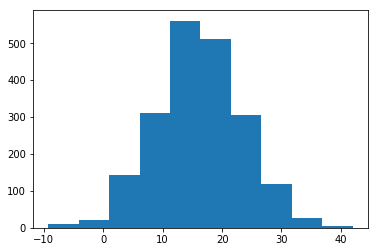

In [172]:
plt.hist(tag_space_pos[:2012].flatten().detach().numpy())

(array([   7.,   29.,   70.,  219.,  549., 1150., 1695.,  957.,  290.,
          34.]),
 array([-65.42404  , -55.795574 , -46.167107 , -36.538643 , -26.910175 ,
        -17.281708 ,  -7.653242 ,   1.9752245,  11.603691 ,  21.232159 ,
         30.860624 ], dtype=float32),
 <a list of 10 Patch objects>)

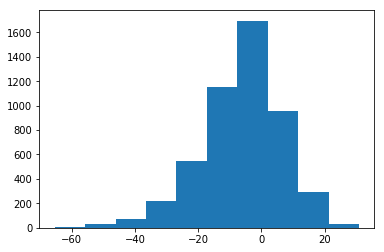

In [186]:
plt.hist(tag_space_neg.flatten().detach().numpy())

In [173]:
pca_attn_pos = PCA(attn_applied_pos, 1)
pca_attn_neg = PCA(attn_applied_neg, 1)

/home/hirak/miniconda2/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


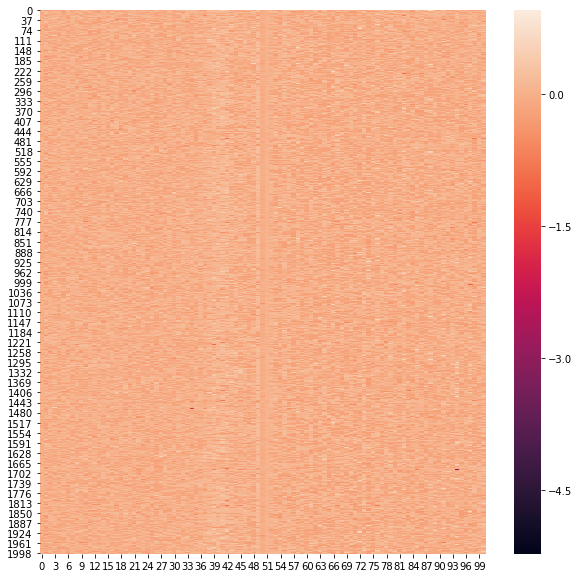

In [178]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(np.log(np.array(pca_attn_pos[:2000])+1),ax = ax)

/home/hirak/miniconda2/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


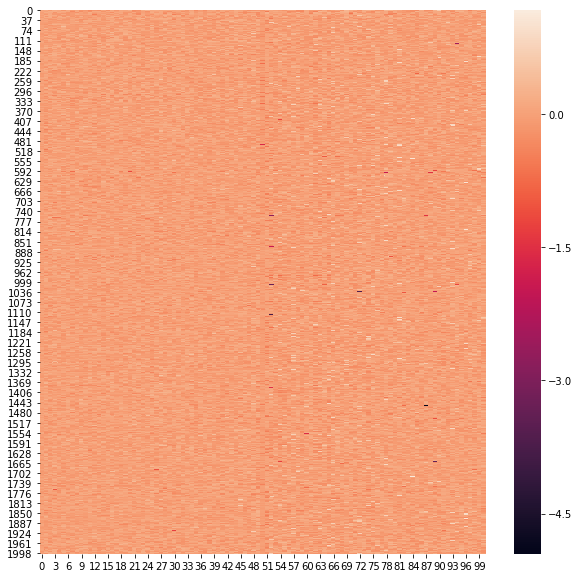

In [179]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(np.log(np.array(pca_attn_neg[:2000])+1),ax = ax)